<a href="https://colab.research.google.com/github/Javier1224/Reconocimiento_Leucemia/blob/main/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se cargan las librerías a utilizar durante el desarrollo del proyecto

In [2]:
from IPython import get_ipython
from IPython.display import display
# %%
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
import os

import skimage
import skimage.color as skic # operaciones con color
from skimage.color import rgb2gray # Importar rgb2gray
import skimage.filters as skif # filtros
import skimage.util as sku # utilidades
import skimage.metrics as skm # métricas
from skimage import segmentation as seg # Segmentación
import skimage.io as skio

from skimage.exposure import histogram
from skimage.transform import resize
from skimage import img_as_float, exposure
from skimage.feature import hog
#from skimage.feature import greycomatrix, greycoprops
from skimage import color, data, transform
from skimage.feature import canny

  # Importar skimage.io para cargar la imagen
import matplotlib.image as mpimg
import cv2


# Para poder hacer la segmentacion
from sklearn.model_selection import train_test_split


Se recupera la información de la base de datos desde el repositorio

In [3]:
!wget -q https://github.com/Javier1224/Reconocimiento_Leucemia/releases/download/Eliza/Datos.zip
!unzip -q Datos.zip

Se crean las funciones necesarias para manipular la información

In [22]:
#Funcion para mostrar la imagen
def cargar_imagenes_por_carpeta(ruta):
  images = []
  imagen_con_Tag = []
  for filename in os.listdir(ruta):
      if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
          image_path = os.path.join(ruta, filename)
          image = skio.imread(image_path)


          # Extraer etiqueta desde el nombre de archivo (hasta el primer guión bajo por ejemplo)
          label = filename.split('-')[-2]
          imagen_con_Tag.append((image,label))
          #images.append(imagen_con_Tag)
  return imagen_con_Tag


def show(img):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img, cmap=plt.cm.gray) # usar pyplot biultin colormap gray
    ax.set_axis_off()
    plt.show()

def show_images_side_by_side(images, names):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 8, 8))

    for index, (img, name) in enumerate(zip(images, names)):
        axes[index].imshow(img, cmap=plt.cm.gray)
        axes[index].set_title(name)

    plt.show()

def linear_contrast_adjustment(image, min_intensity, max_intensity):
    # Ajusta el contraste linealmente
    adjusted_image = np.clip((image - min_intensity) * (255.0 / (max_intensity - min_intensity)), 0, 255)
    return adjusted_image.astype(np.uint8)

def showPair(image1, image2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image1, cmap='gray')
    ax1.axis('off')
    ax1.set_title('Imagen')
    ax2.imshow(image2, cmap='gray')
    ax2.axis('off')
    ax2.set_title('Imagen con bordes')
    plt.show()

def aplicar_espejo(imagen):
    return imagen.transpose(Image.FLIP_LEFT_RIGHT)

def crear_directorio(ruta):
    if not os.path.exists(ruta):
        os.makedirs(ruta)

# Mínimo requerido de imágenes de entrenamiento
minimo_entrenamiento = 458

Funciones para realizar data augmentation

In [24]:
# Simulación de augmentar_imagen para rotaciones y reflejos
def augmentar_imagen(imagen):
    transformacion = random.choice(['rot90', 'rot270', 'flip'])
    if transformacion == 'rot90':
        return np.rot90(imagen, k=1)
    elif transformacion == 'rot270':
        return np.rot90(imagen, k=3)
    elif transformacion == 'flip':
        return np.fliplr(imagen)
    return imagen  # En caso de fallo

# Función principal que separa y aumenta
def procesar_y_aumentar_balanceado(carpetaRaiz):
    datos_entrenamiento = []
    datos_prueba = []

    subconjuntos_train = []
    subconjuntos_test = []

    # 1. Separar 80/20 por clase
    for clase in carpetaRaiz:
        train, test = train_test_split(clase, test_size=0.2, random_state=42)
        subconjuntos_train.append(train)
        subconjuntos_test.append(test)

    # 2. Calcular el tamaño máximo de los subconjuntos de entrenamiento
    max_train_len = max(len(train) for train in subconjuntos_train)

    # 3. Aplicar aumento de datos para balancear
    for train in subconjuntos_train:
        clase_aug = deepcopy(train)
        faltantes = max_train_len - len(train)

        for _ in range(faltantes):
            imagen_original, etiqueta = random.choice(train)
            imagen_transformada = augmentar_imagen(imagen_original)
            clase_aug.append((imagen_transformada, etiqueta + '_aug'))

        datos_entrenamiento.append(clase_aug)

    # 4. Agregar los subconjuntos de prueba tal cual están
    datos_prueba = subconjuntos_test

    return datos_entrenamiento, datos_prueba


Ahora, se debe cargar las rutas desde las cuales cargar los datos a variables en python con las que poder trabajar

In [27]:
# Se cargar cada carpeta de imagenes en una variable en particular
Benign = "/content/Original/Benign"
Early = "/content/Original/Early"
Pro = "/content/Original/Pre"
Pre = "/content/Original/Pro"

celulas = [Benign,Early,Pro,Pre]
celulasTag = ["Benign","Early","Pro","Pre"]
carpetaRaiz = []
for ruta in celulas:
  carpetaRaiz.append(cargar_imagenes_por_carpeta(ruta))

for folder in range(len(carpetaRaiz)):
  print(f'La cantidad de imagenes de {celulasTag[folder]} es {len(carpetaRaiz[folder])}')

La cantidad de imagenes de Benign es 504
La cantidad de imagenes de Early es 985
La cantidad de imagenes de Pro es 963
La cantidad de imagenes de Pre es 804


La estructura a manejar con los datos cargados es la siguiente:


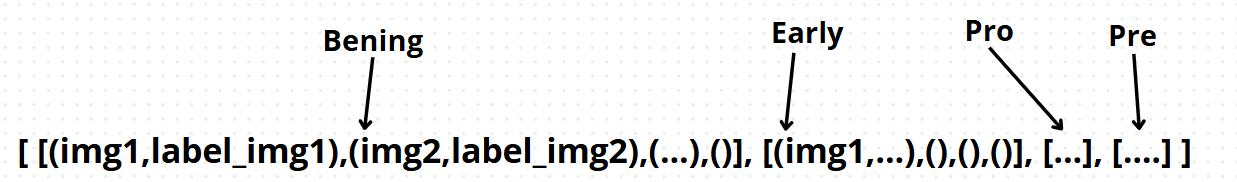

Se aplica el balanceo de carga en base a aplicar transformaciones de rotación de 90 grados y reflexión de las imágenes

In [28]:
data_Train, data_Test = procesar_y_aumentar_balanceado(carpetaRaiz)

#print(len(data_Train[0]))

for i in range(len(data_Train)):
  #print(i)
  print(f"Categoría {celulasTag[i]} ahora tiene: {len(data_Train[i])} imágenes")

Categoría Benign ahora tiene: 788 imágenes
Categoría Early ahora tiene: 788 imágenes
Categoría Pro ahora tiene: 788 imágenes
Categoría Pre ahora tiene: 788 imágenes


Se define la función que hará el procesamiento de la información para una entrada de datos determinada.

In [29]:
def preprocesar_imagenes(data):
  Preprocesada = []
  for folder in range(len(data)):
      images = data[folder]
      images_preprocesadas = []
      cant_muestras_sh = 0

      for i in range(len(images)):
          # Entrada
          img_rgb = images[i][0]
          label_img = images[i][1]

          # Convertir a HSV
          img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

          # Segmentación por umbral HSV
          lower = np.array([120, 70, 70])
          upper = np.array([180, 255, 255])
          mask = cv2.inRange(img_hsv, lower, upper)
          segmented = cv2.bitwise_and(img_hsv, img_hsv, mask=mask)

          # Convertir a RGB para modelos preentrenados que esperan RGB
          segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_HSV2RGB)

          # Redimensionar a 224x224
          resized = cv2.resize(segmented_rgb, (224, 224), interpolation=cv2.INTER_AREA)

          # Normalización [0,1]
          normalized = resized / 255.0

          # Agregar imagen con su etiqueta
          images_preprocesadas.append((normalized, label_img))

          # Visualizar solo las dos primeras por clase
          if cant_muestras_sh < 2:
              fig, axs = plt.subplots(1, 4, figsize=(10, 2.5))
              axs[0].imshow(img_rgb)
              axs[0].set_title(label_img)
              axs[1].imshow(img_hsv)
              axs[1].set_title("HSV")
              axs[2].imshow(mask, cmap='gray')
              axs[2].set_title("Máscara binaria")
              axs[3].imshow(resized)
              axs[3].set_title("Segmentado y Redimensionado")
              for ax in axs:
                  ax.axis('off')
              plt.tight_layout()
              plt.show()
          cant_muestras_sh += 1

      Preprocesada.append(tuple(images_preprocesadas))
  return Preprocesada

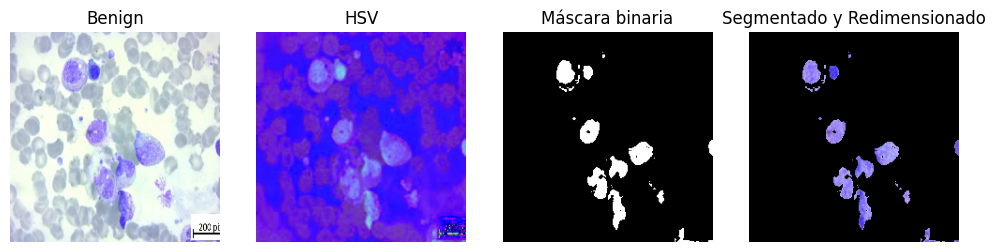

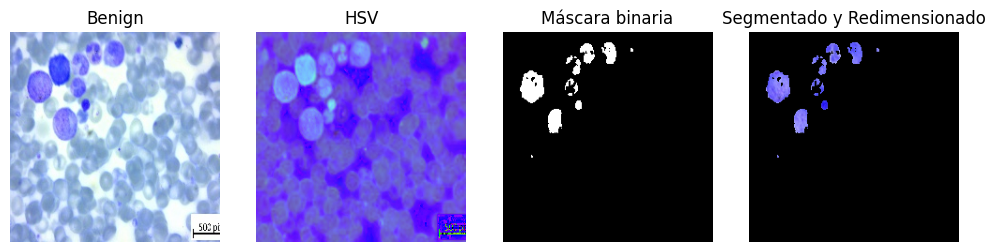

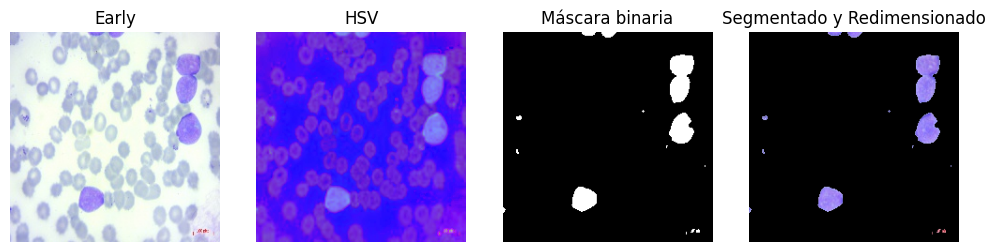

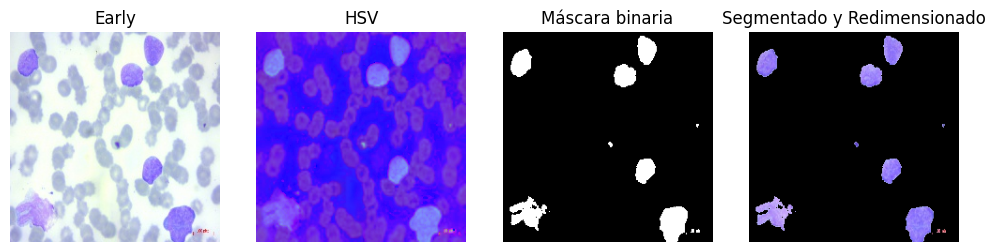

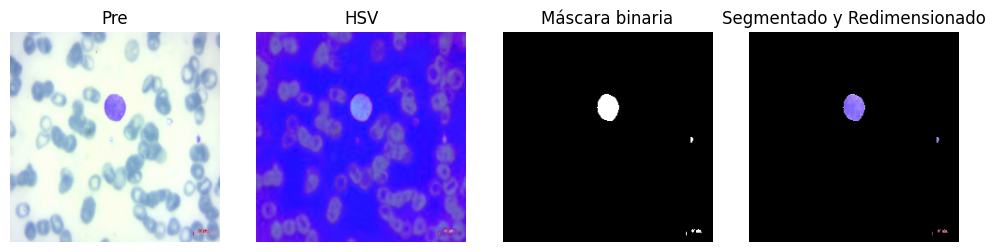

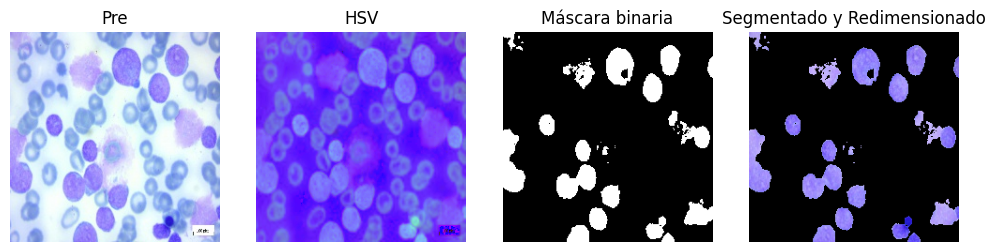

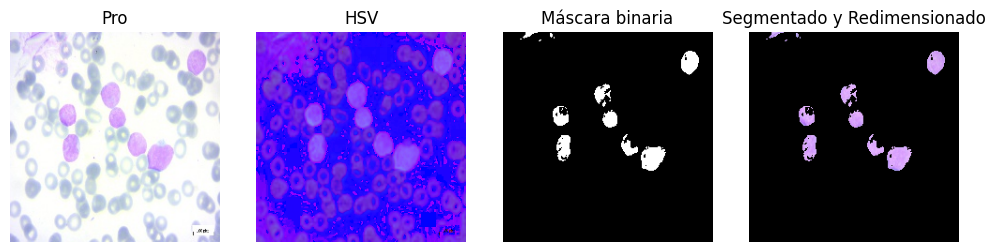

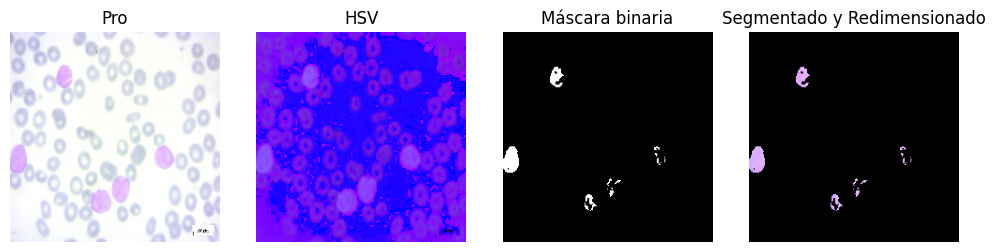

In [30]:
DataTrain_Preprocesada = preprocesar_imagenes(data_Train)

## USAR ESTAS LINEAS EN CASO DE QUERER VER EL TAMAÑO DE CADA CLASE
#for folder in range(len(DataTrain_Preprocesada)):
#  print(f'La cantidad de imagenes de {celulasTag[folder]} es {len(DataTrain_Preprocesada[folder])}')

## Entrenamiento del modelo

In [31]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np

In [32]:
# Crear listas planas de imágenes y etiquetas
imagenes = []
etiquetas = []

for clase in DataTrain_Preprocesada:
    for imagen, etiqueta in clase:
        imagenes.append(tf.image.resize(imagen, [224, 224]))  # asegúrate del tamaño
        etiquetas.append(etiqueta)

imagenes = np.array(imagenes)

# Convertimos etiquetas tipo texto a valores numéricos
etiquetas_unicas = sorted(set(etiquetas))
mapa_etiquetas = {nombre: idx for idx, nombre in enumerate(etiquetas_unicas)}
etiquetas_num = np.array([mapa_etiquetas[et] for et in etiquetas])
etiquetas_cat = to_categorical(etiquetas_num)

In [33]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Congela los pesos

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [34]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(etiquetas_unicas), activation='softmax')(x)

modelo = Model(inputs=base_model.input, outputs=output)

In [35]:
modelo.compile(optimizer=Adam(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [36]:
modelo.fit(imagenes, etiquetas_cat, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 552s 7s/step - accuracy: 0.4419 - loss: 1.6001 - val_accuracy: 0.0000e+00 - val_loss: 3.1554
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 561s 7s/step - accuracy: 0.5463 - loss: 1.2216 - val_accuracy: 0.0000e+00 - val_loss: 3.0323
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 537s 7s/step - accuracy: 0.5540 - loss: 1.1645 - val_accuracy: 0.0000e+00 - val_loss: 3.2307
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 567s 7s/step - accuracy: 0.5488 - loss: 1.1299 - val_accuracy: 0.0000e+00 - val_loss: 3.2377
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 516s 6s/step - accuracy: 0.5590 - loss: 1.1249 - val_accuracy: 0.0000e+00 - val_loss: 3.3042
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 542s 7s/step - accuracy: 0.6147 - loss: 1.0652 - val_accuracy: 0.0000e+00 - val_loss: 3.1775
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 563s 7s/step - accuracy: 0.6177 - loss: 1.0489 - val_accuracy: 0.0000e+00 - val_loss: 3.2302
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 519s 6s/step - accuracy: 0.6350 - loss: 1.038

In [39]:
# Extraer imágenes y etiquetas
X_test = np.array([cv2.resize(img, (224, 224)) for img, _ in data_Test])
y_test = [limpiar_etiqueta(etiqueta) for _, etiqueta in data_Test]

ValueError: too many values to unpack (expected 2)